In [121]:
import os
import tarfile
import urllib

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer
from pandas.plotting import scatter_matrix
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from scipy.stats import randint
from scipy import stats
from sklearn.metrics import r2_score

In [122]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

### Load data

In [123]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [124]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [125]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [126]:
# Select just the rows desired from the 'describe' method and add in the 'median'
stats_df = housing.describe()
stats_df.loc['range'] = stats_df.loc['max'] - stats_df.loc['min']

out_fields = ['mean','25%','50%','75%', 'range']
stats_df = stats_df.loc[out_fields]
stats_df.rename({'50%': 'median'}, inplace=True)
stats_df
### END SOLUTION

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.53968,3.870671,206855.816909
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.00000,2.563400,119600.000000
median,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.00000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.00000,4.743250,264725.000000
range,10.040000,9.410000,51.000000,39318.000000,6444.000000,35679.000000,6081.00000,14.500200,485002.000000


### Outliers

In [127]:
q25, q50, q75 = np.percentile(housing['median_house_value'], [25, 50, 75])
iqr = q75 - q25

min = q25 - 1.5*(iqr)
max = q75 + 1.5*(iqr)

print (min, q25, q50, q75, max)

-98087.5 119600.0 179700.0 264725.0 482412.5


In [128]:
#identifying the outlier
[x for x in housing['median_house_value'] if x> max]

[500001.0,
 483300.0,
 500001.0,
 489600.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 494000.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 499000.0,
 500001.0,
 500001.0,
 500001.0,
 485400.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 483500.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 483100.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 495500.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 490800.0,
 500001.0,
 500001.0,
 495600.0,
 500001.0,
 500001.0,
 483800.0,
 500001.0,
 497600.0,
 500001.0,
 500001.0,
 495600.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 500001.0,
 498700.0,
 500001.0,
 500001.0,

In [129]:
housing['median_house_value'].value_counts()

500001.0    965
137500.0    122
162500.0    117
112500.0    103
187500.0     93
           ... 
303200.0      1
307900.0      1
383200.0      1
360800.0      1
405500.0      1
Name: median_house_value, Length: 3842, dtype: int64

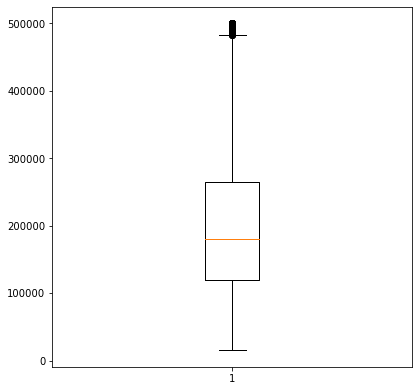

In [130]:
data = housing['median_house_value']
  
fig = plt.figure(figsize =(5, 5))
  
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
  
# Creating plot
bp = ax.boxplot(data)
  
# show plot
plt.show()

##### most houses are in range 500,000. SO, we keep the valeus even though they are outliers

### Cleaning

In [131]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

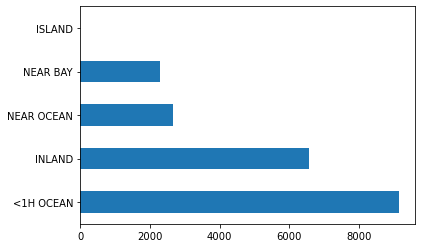

In [132]:
housing['ocean_proximity'].value_counts().plot(kind = 'barh')

In [133]:
housing['ocean_proximity'] = housing.ocean_proximity.str.replace('<1H OCEAN', 'OCEAN')
housing['ocean_proximity'].value_counts()

OCEAN         9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

### Agreegrations

In [134]:
housing.groupby('ocean_proximity').mean()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
ocean_proximity,,,,,,,,,
INLAND,-119.732990,36.731829,24.271867,2717.742787,533.881619,1391.046252,477.447565,3.208996,124805.392001
ISLAND,-118.354000,33.358000,42.400000,1574.600000,420.400000,668.000000,276.600000,2.744420,380440.000000
NEAR BAY,-122.260694,37.801057,37.730131,2493.589520,514.182819,1230.317467,488.616157,4.172885,259212.311790
NEAR OCEAN,-119.332555,34.738439,29.347254,2583.700903,538.615677,1354.008653,501.244545,4.005785,249433.977427
OCEAN,-118.847766,34.560577,29.279225,2628.343586,546.539185,1520.290499,517.744965,4.230682,240084.285464


In [135]:
housing.groupby('ocean_proximity').median()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
ocean_proximity,,,,,,,,,
INLAND,-120.000,36.97,23.0,2131.0,423.0,1124.0,385.0,2.98770,108500.0
ISLAND,-118.320,33.34,52.0,1675.0,512.0,733.0,288.0,2.73610,414700.0
NEAR BAY,-122.250,37.79,39.0,2083.0,423.0,1033.5,406.0,3.81865,233800.0
NEAR OCEAN,-118.260,33.79,29.0,2195.0,464.0,1136.5,429.0,3.64705,229450.0
OCEAN,-118.275,34.03,30.0,2108.0,438.0,1247.0,421.0,3.87500,214850.0


In [136]:
housing.groupby('ocean_proximity').agg(['mean', 'median'])

longitude            latitude        housing_median_age  \
                       mean   median       mean median               mean   
ocean_proximity                                                             
INLAND          -119.732990 -120.000  36.731829  36.97          24.271867   
ISLAND          -118.354000 -118.320  33.358000  33.34          42.400000   
NEAR BAY        -122.260694 -122.250  37.801057  37.79          37.730131   
NEAR OCEAN      -119.332555 -118.260  34.738439  33.79          29.347254   
OCEAN           -118.847766 -118.275  34.560577  34.03          29.279225   

                        total_rooms         total_bedrooms         \
                median         mean  median           mean median   
ocean_proximity                                                     
INLAND            23.0  2717.742787  2131.0     533.881619  423.0   
ISLAND            52.0  1574.600000  1675.0     420.400000  512.0   
NEAR BAY          39.0  2493.589520  2083.0     514.182819  423.0   
NEAR OCEAN        29.0  2583.700903  2195.0     538.615677  464.0   
OCEAN             30.0  2628.343586  2108.0     546.539185  438.0   

                  population          households        median_income  \
                        mean  median        mean median          mean   
ocean_proximity                                                         
INLAND           1391.046252  1124.0  477.447565  385.0      3.208996   
ISLAND            668.000000   733.0  276.600000  288.0      2.744420   
NEAR BAY         1230.317467  1033.5  488.616157  406.0      4.172885   
NEAR OCEAN       1354.008653  1136.5  501.244545  429.0      4.005785   
OCEAN            1520.290499  1247.0  517.744965  421.0      4.230682   

                         median_house_value            
                  median               mean    median  
ocean_proximity                                        
INLAND           2.98770      124805.392001  108500.0  
ISLAND           2.73610      380440.000000  414700.0  
NEAR BAY         3.81865      259212.311790  233800.0  
NEAR OCEAN       3.64705      249433.977427  229450.0  
OCEAN            3.87500      240084.285464  214850.0

### Data Splitting

In [137]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [138]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


### Cross Validation

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002D4B6EBBD90>,
      dtype=object)

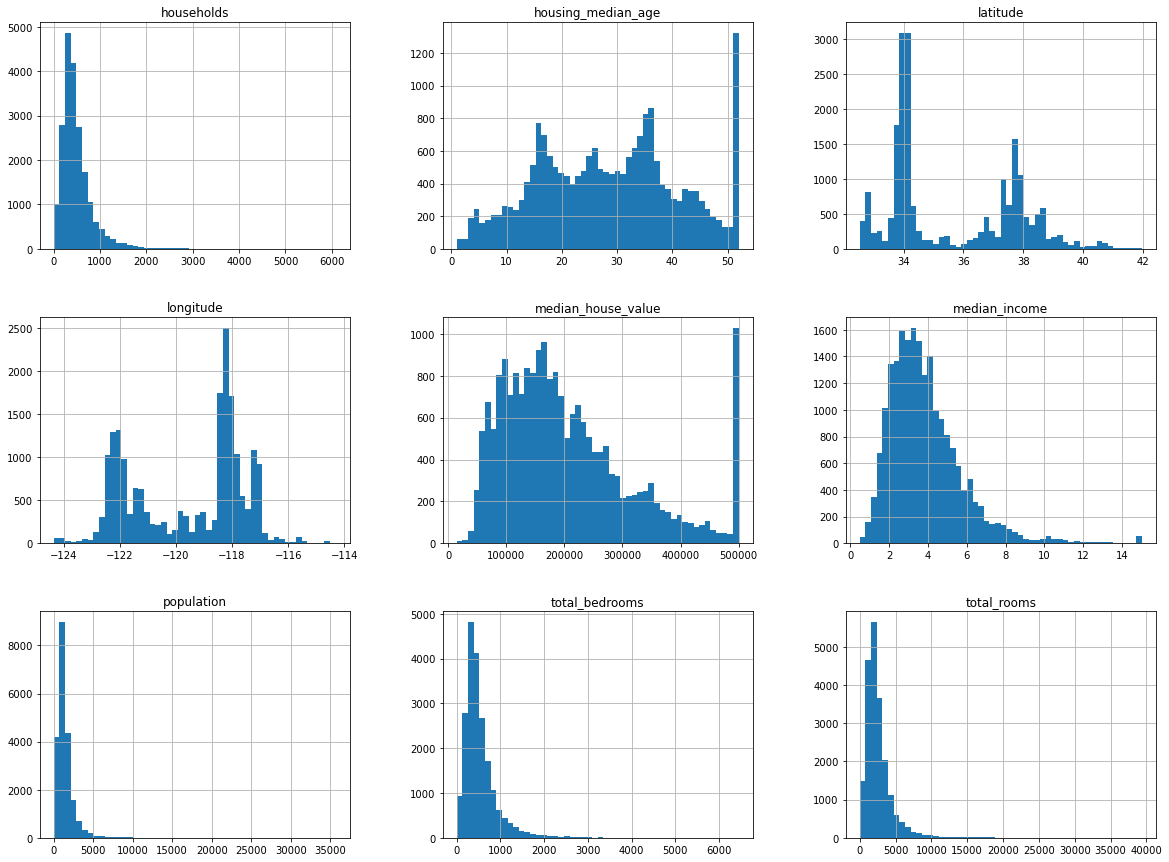

In [139]:
housing.hist(bins=50, figsize=(20,15))

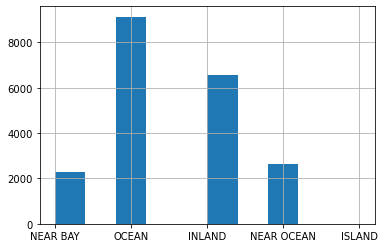

In [140]:
housing["ocean_proximity"].hist()

INLAND             AxesSubplot(0.1,0.679412;0.363636x0.220588)
ISLAND        AxesSubplot(0.536364,0.679412;0.363636x0.220588)
NEAR BAY           AxesSubplot(0.1,0.414706;0.363636x0.220588)
NEAR OCEAN    AxesSubplot(0.536364,0.414706;0.363636x0.220588)
OCEAN                  AxesSubplot(0.1,0.15;0.363636x0.220588)
dtype: object

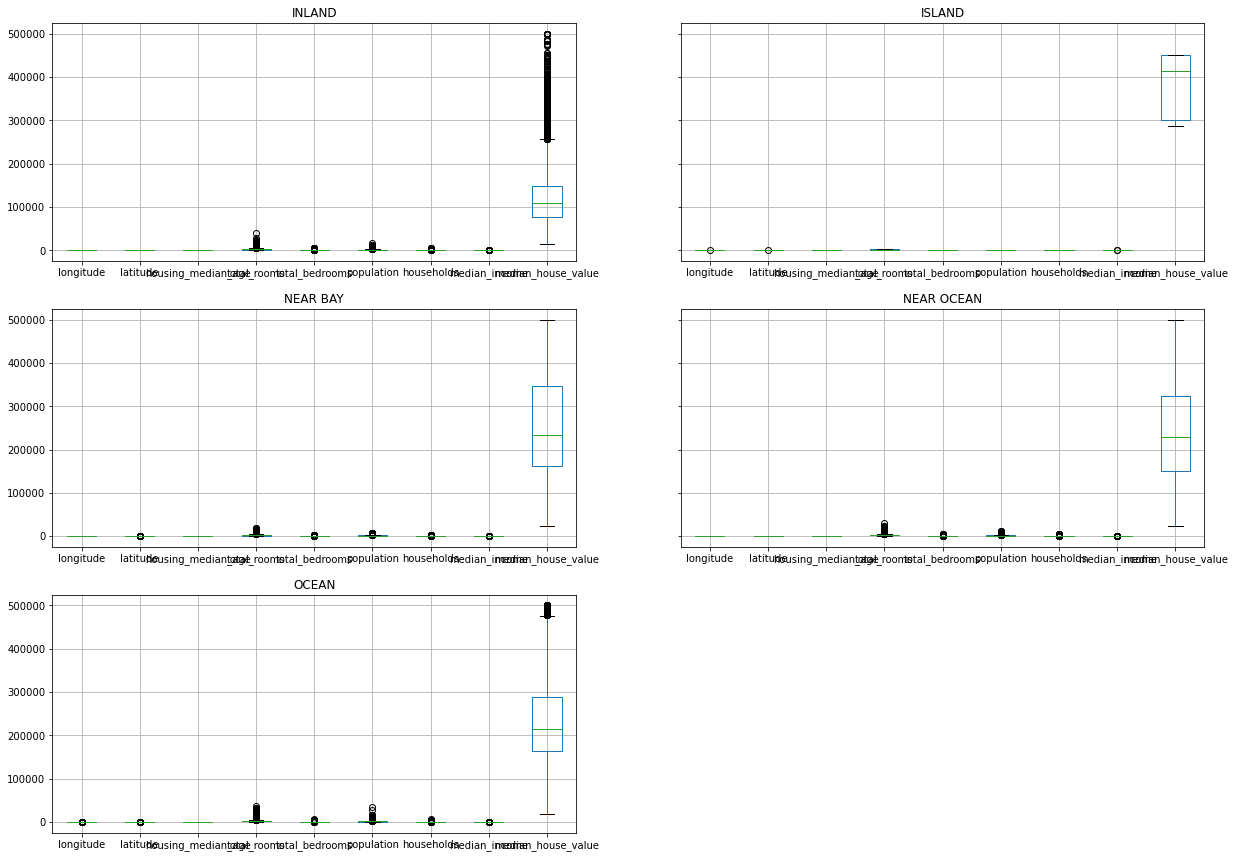

In [141]:
housing.groupby('ocean_proximity').boxplot(figsize=(20,15))

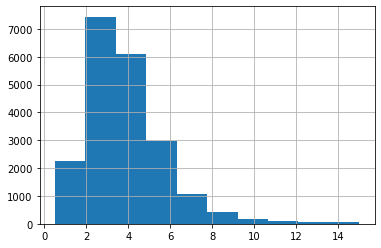

In [142]:
housing["median_income"].hist()

In [143]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

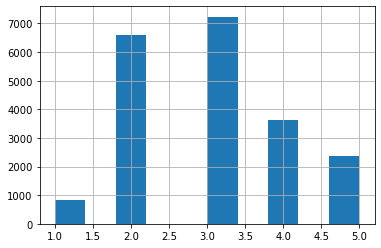

In [144]:
housing["income_cat"].hist()

###### Since, we see that the data in income cateogory is not spread across, we use stratified shuffle split in order to get the features in both training and test data sets

In [145]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [146]:
strat_train_set.shape

(16512, 11)

In [147]:
strat_test_set.shape

(4128, 11)

In [148]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [149]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [150]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


##### if you observe, using stratified, the overall error is very less compared to random split. This is used in some cases only

In [151]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

##### drop the row after analysis

### EDA

In [152]:
housing = strat_train_set.copy()

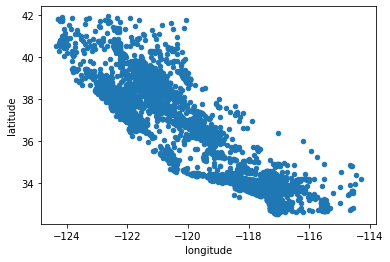

In [153]:
housing.plot(kind="scatter", x="longitude", y="latitude")

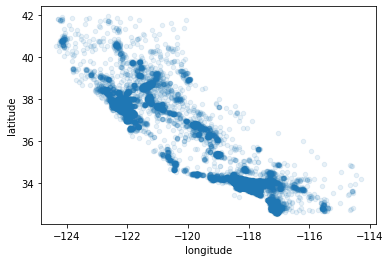

In [154]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

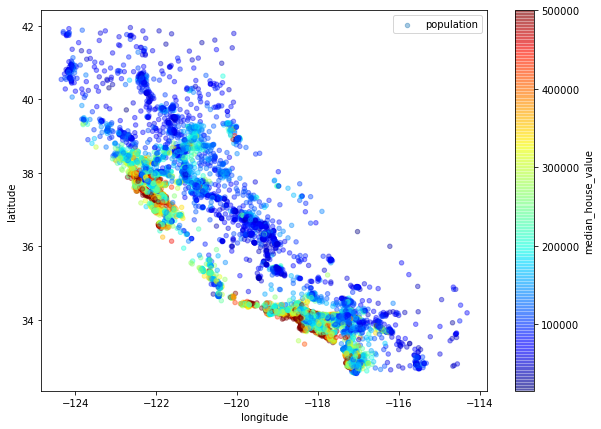

In [155]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, label="population",
            figsize=(10,7), c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

In [156]:
corr_matrix = housing.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


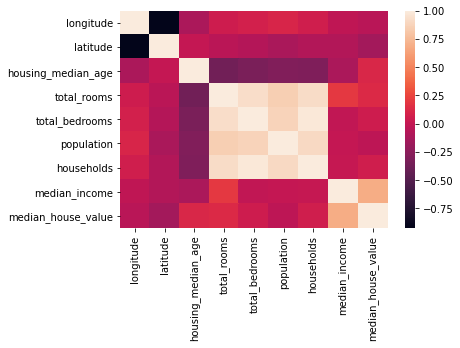

In [157]:
sns.heatmap(corr_matrix)

In [158]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002D4B7E5AD60>,
      dtype=object)

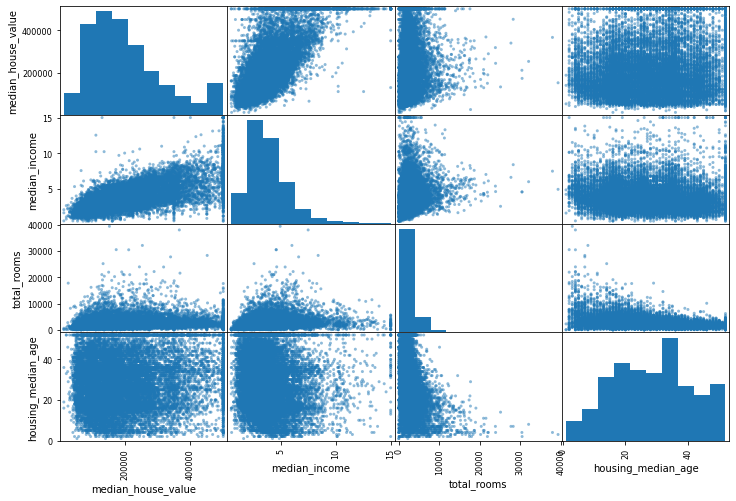

In [159]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

(0.0, 16.0, 0.0, 550000.0)

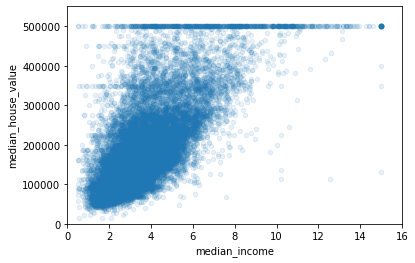

In [160]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])

##### positive correlation with house value and income, the straight lines can be reoved are placed as it is.

### Adding more features with help of existing features to increase correlations

In [161]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,OCEAN,4.625369,0.223852,2.094395
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,OCEAN,6.008850,0.159057,2.707965
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN,4.225108,0.241291,2.025974
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND,5.232295,0.200866,4.135977
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,OCEAN,4.505810,0.231341,3.047847
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,240200.0,INLAND,6.052381,0.185681,2.728571
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,113000.0,INLAND,4.635659,0.245819,4.077519
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,97800.0,INLAND,6.346405,0.179609,2.742484
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,225900.0,OCEAN,5.505618,0.193878,3.808989


In [162]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

##### negative correaltion also helps

### Agrregating Null Values

In [163]:
X_Train = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set temporarily
Y_Train = strat_train_set["median_house_value"].copy()

In [164]:
sample_incomplete_rows = X_Train[X_Train.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,OCEAN


In [165]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1 (drop rows -- bad idea :-( )

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [166]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2 (drop column -- very bad idea :-( )

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,OCEAN


In [167]:
median = X_Train["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3

In [168]:
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,OCEAN


In [169]:
sample_incomplete_rows.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
ocean_proximity       0
dtype: int64

In [170]:
housing.isnull().sum()

longitude                     0
latitude                      0
housing_median_age            0
total_rooms                   0
total_bedrooms              158
population                    0
households                    0
median_income                 0
median_house_value            0
ocean_proximity               0
rooms_per_household           0
bedrooms_per_room           158
population_per_household      0
dtype: int64

In [171]:
median = X_Train["total_bedrooms"].median()
X_Train["total_bedrooms"].fillna(median, inplace=True) #use this

In [172]:
X_Train.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
ocean_proximity       0
dtype: int64

In [173]:
X_Train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,OCEAN


### using imputer

In [174]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [175]:
housing_num = X_Train.drop("ocean_proximity", axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])
# remove text columns because imputer cannot detect text

In [176]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [177]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

###### transform data

In [178]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


In [179]:
housing_tr.isnull().any()

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms        False
population            False
households            False
median_income         False
dtype: bool

### Feature Engineering

#### get_dummies

In [180]:
one_hot_encode_cols = X_Train.dtypes[X_Train.dtypes == np.object]  
one_hot_encode_cols = one_hot_encode_cols.index.tolist()
housing = pd.get_dummies(housing, columns=one_hot_encode_cols, drop_first=True)
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,ocean_proximity_OCEAN
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,4.625369,0.223852,2.094395,0,0,0,1
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,6.008850,0.159057,2.707965,0,0,0,1
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,4.225108,0.241291,2.025974,0,0,1,0
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,5.232295,0.200866,4.135977,0,0,0,0
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,4.505810,0.231341,3.047847,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,240200.0,6.052381,0.185681,2.728571,0,0,0,0
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,113000.0,4.635659,0.245819,4.077519,0,0,0,0
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,97800.0,6.346405,0.179609,2.742484,0,0,0,0
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,225900.0,5.505618,0.193878,3.808989,0,0,0,1


In [181]:
# Select the object (string) columns
mask = X_Train.dtypes == np.object
categorical_cols = X_Train.columns[mask]

# Determine how many extra columns would be created
num_ohc_cols = (X_Train[categorical_cols]
                .apply(lambda x: x.nunique())
                .sort_values(ascending=False))


# No need to encode if there is only one value
small_num_ohc_cols = num_ohc_cols.loc[num_ohc_cols>1]

# Number of one-hot columns is one less than the number of categories
small_num_ohc_cols -= 1
small_num_ohc_cols.sum()

4

SO, there will be 4 new columns added after encoding and removing original column

#### ordinal encoding

In [183]:
#housing_cat = housing[["ocean_proximity"]]
#housing_cat.head(10)

In [184]:
#from sklearn.preprocessing import OrdinalEncoder

#ordinal_encoder = OrdinalEncoder()
#housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
#housing_cat_encoded[:10]

#### One hot encoder

In [185]:
#from sklearn.preprocessing import OneHotEncoder #best used encoder

#cat_encoder = OneHotEncoder()
#housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

#housing_cat_1hot.toarray() #used to convert to numpy array

### Log Transformations for Skewed data

In [186]:
# Create a list of float colums to check for skewing
mask = X_Train.dtypes == np.float
float_cols = X_Train.columns[mask]

skew_limit = 0.75 # define a limit above which we will log transform
skew_vals = X_Train[float_cols].skew()

# Showing the skewed columns
skew_cols = (skew_vals
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0:'Skew'})
             .query('abs(Skew) > {}'.format(skew_limit)))

skew_cols

,Skew
population,4.741063
total_rooms,4.000398
total_bedrooms,3.288232
households,3.221306
median_income,1.653513


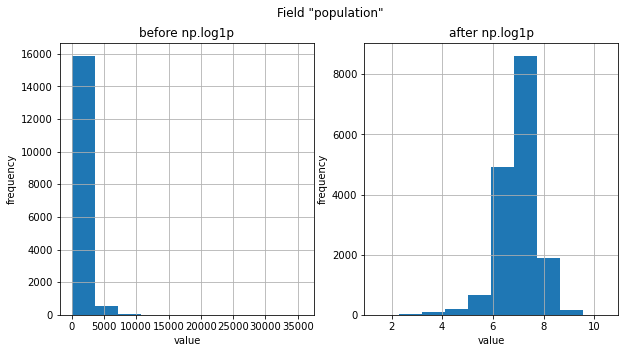

In [187]:
# Let's look at what happens to one of these features, when we apply np.log1p visually.

# Choose a field
field = "population"

# Create two "subplots" and a "figure" using matplotlib
fig, (ax_before, ax_after) = plt.subplots(1, 2, figsize=(10, 5))

# Create a histogram on the "ax_before" subplot
X_Train[field].hist(ax=ax_before)

# Apply a log transformation (numpy syntax) to this column
X_Train[field].apply(np.log1p).hist(ax=ax_after)

# Formatting of titles etc. for each subplot
ax_before.set(title='before np.log1p', ylabel='frequency', xlabel='value')
ax_after.set(title='after np.log1p', ylabel='frequency', xlabel='value')
fig.suptitle('Field "{}"'.format(field));

In [188]:
# Perform the skew transformation:

for col in skew_cols.index.values:
    X_Train[col] = X_Train[col].apply(np.log1p)

### Pipelines

In [189]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

housing_num = X_Train.drop("ocean_proximity", axis=1)
housing_num_tr = num_pipeline.fit_transform(housing_num)

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

New_X_Train = full_pipeline.fit_transform(X_Train)
New_X_Train.shape

(16512, 13)

### Modelling

In [195]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(New_X_Train, Y_Train)

housing_predictions_tr = lin_reg.predict(New_X_Train)
lin_mse = mean_squared_error(Y_Train, housing_predictions_tr)
lin_rmse = np.sqrt(lin_mse)
print('pred score', lin_rmse)

pred score 69674.59419993851


In [196]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(New_X_Train, Y_Train)

housing_predictions = tree_reg.predict(New_X_Train)
tree_mse = mean_squared_error( Y_Train, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print('pred score', tree_rmse)

pred score 0.0


Huge Overfitting

In [198]:
from sklearn.ensemble import RandomForestRegressor

tree_reg = RandomForestRegressor(random_state=42)
tree_reg.fit(New_X_Train, Y_Train)

housing_predictions = tree_reg.predict(New_X_Train)
tree_mse = mean_squared_error( Y_Train, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print('pred score', tree_rmse)

pred score 18366.632787051585


### Tuning Model

In [65]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [66]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(New_X_Train, Y_Train)

scores = cross_val_score(tree_reg, New_X_Train, Y_Train,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

display_scores(tree_rmse_scores)

Scores: [67001.57279988 66227.11531684 73352.25458359 69809.82814266
 68302.83449849 74644.21476161 66981.31800009 70099.40130467
 69950.6208109  69356.14438054]
Mean: 69572.53045992754
Standard deviation: 2581.861925991812


In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(New_X_Train, Y_Train)

lin_scores = cross_val_score(lin_reg, New_X_Train, Y_Train ,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [69964.68261065 69395.10652988 70626.70375219 71116.86535265
 68216.86069084 72601.38706145 67036.16165339 67906.11207397
 72496.23479655 68323.63853528]
Mean: 69768.37530568462
Standard deviation: 1833.7848837263828


In [68]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(New_X_Train, Y_Train)

forest_scores = cross_val_score(forest_reg,New_X_Train, Y_Train,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [48188.95700343 46342.94777019 49277.55695399 50137.13850793
 49316.49391545 53009.34555084 49133.44578409 50454.54060457
 51358.52417509 49454.97418597]
Mean: 49667.392445155194
Standard deviation: 1694.457626239963


### Automatic Tuning

#### Grid Search CV

In [199]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(New_X_Train, Y_Train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [200]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30, random_state=42)

In [201]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64398.01181613511 {'max_features': 2, 'n_estimators': 3}
55592.57553797483 {'max_features': 2, 'n_estimators': 10}
52735.6582298959 {'max_features': 2, 'n_estimators': 30}
60585.684049451855 {'max_features': 4, 'n_estimators': 3}
53377.83113265766 {'max_features': 4, 'n_estimators': 10}
50768.86786862544 {'max_features': 4, 'n_estimators': 30}
60423.851303502975 {'max_features': 6, 'n_estimators': 3}
53047.26276161143 {'max_features': 6, 'n_estimators': 10}
50341.029964258916 {'max_features': 6, 'n_estimators': 30}
58713.23891062671 {'max_features': 8, 'n_estimators': 3}
52567.76641917024 {'max_features': 8, 'n_estimators': 10}
50413.46870470675 {'max_features': 8, 'n_estimators': 30}
63670.18439757307 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54494.644023217814 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60717.54731968271 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53389.68620448655 {'bootstrap': False, 'max_features': 3, 'n_estimators':

In [202]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([1.11416204e-01, 1.02632202e-01, 4.89678291e-02, 3.82068958e-02,
       3.11062066e-02, 4.63781239e-02, 2.99909670e-02, 4.08790697e-01,
       1.56588402e-01, 5.99184157e-05, 5.10433556e-03, 6.05243346e-03,
       1.47057855e-02])

In [211]:
ft = list(zip(housing.columns, feature_importances.tolist()))
ft

[('longitude', 0.11141620393492448),
 ('latitude', 0.10263220156072388),
 ('housing_median_age', 0.04896782911214239),
 ('total_rooms', 0.03820689583062145),
 ('total_bedrooms', 0.03110620661065194),
 ('population', 0.04637812390935677),
 ('households', 0.02999096697864265),
 ('median_income', 0.4087906970794835),
 ('median_house_value', 0.15658840205681807),
 ('rooms_per_household', 5.991841567278587e-05),
 ('bedrooms_per_room', 0.005104335556062655),
 ('population_per_household', 0.006052433461577678),
 ('ocean_proximity_ISLAND', 0.014705785493321967)]

In [233]:
a = pd.DataFrame(ft)
col = [['Features', 'Imp']]
a.columns = col
a

,Features,Imp
0,longitude,0.111416
1,latitude,0.102632
2,housing_median_age,0.048968
3,total_rooms,0.038207
4,total_bedrooms,0.031106
5,population,0.046378
6,households,0.029991
7,median_income,0.408791
8,median_house_value,0.156588
9,rooms_per_household,0.000060


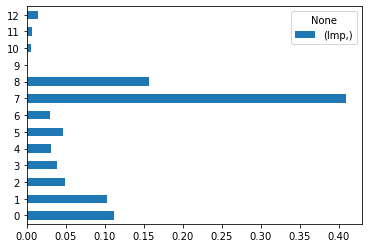

In [234]:
a.plot(kind = 'barh')

#### randomized search cv

In [68]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg,
                                param_distributions=param_distribs,
                                n_iter=10, cv=5, 
                                scoring='neg_mean_squared_error',
                                random_state=42)
rnd_search.fit(New_X_Train, Y_Train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001ADC6E37490>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001ADC723E9D0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [69]:
rnd_search.best_estimator_

RandomForestRegressor(max_features=7, n_estimators=180, random_state=42)

### Evaluating Results and Developing a single pipeline

#### grid search

In [88]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
print('rmse :', np.sqrt(final_mse))

rmse : 232837.92815930326


-3.1601433744479683

In [87]:
gr = grid_search.best_estimator_.fit(New_X_Train, Y_Train)
print('R-squared score (training): {:.3f}'
     .format(gr.score(New_X_Train, Y_Train)))
print('R-squared score (test): {:.3f}\n'
     .format(gr.score(X_test_prepared, y_test)))

R-squared score (training): 0.972
R-squared score (test): -3.160



In [154]:
ex = ([[-122.23, 37.88, 41.0, 880.0, 129.0, 322.0, 126.0, 8.3252, 'NEAR BAY']])
output = 452600

In [161]:
data = (-122.23, 37.88, 41.0, 880.0, 129.0, 322.0, 126.0, 8.3252, 'NEAR BAY')
p = final_model.predict(full_pipeline.fit_transform([data]))
print(p)

ValueError: Specifying the columns using strings is only supported for pandas DataFrames

In [113]:
a = pd.DataFrame(X_test_prepared)
a

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.592384,-0.710749,0.027588,8643.726146,1399.553150,2960.516162,1318.033433,18.859279,0.0,0.0,0.0,0.0,1.0
1,0.857146,-0.874454,0.822858,5572.488489,902.866958,2260.157192,891.131545,8.624744,0.0,0.0,0.0,0.0,1.0
2,0.262681,-0.668654,-0.131466,5838.268671,1279.903255,2859.882058,1201.982434,4.165660,0.0,0.0,0.0,0.0,1.0
3,0.712276,-0.673331,1.856709,2387.153279,417.310989,1374.849056,436.598466,7.344068,1.0,0.0,0.0,0.0,0.0
4,0.947065,-0.734136,0.266169,2372.387713,428.441212,1441.485152,408.967275,7.025363,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4123,-0.976205,1.375319,0.345696,6685.275210,1617.983772,3273.297838,1476.912777,1.268315,1.0,0.0,0.0,0.0,0.0
4124,-0.431695,-0.462853,0.107115,3030.126547,703.914226,1897.058463,642.450833,1.274449,0.0,0.0,0.0,1.0,0.0
4125,0.542429,-0.682686,0.186642,4114.724461,929.301237,2011.291771,936.723008,9.425829,0.0,0.0,0.0,0.0,1.0
4126,1.126903,-0.771554,-0.131466,7324.221506,1174.166139,3254.258953,1146.720054,8.903298,1.0,0.0,0.0,0.0,0.0


In [148]:
y_test

5241     500001.0
10970    240300.0
20351    218200.0
6568     182100.0
13285    121300.0
           ...   
20519     76400.0
17430    134000.0
4019     311700.0
12107    133500.0
2398      78600.0
Name: median_house_value, Length: 4128, dtype: float64

In [149]:
final_predictions

array([499364.88333333, 469806.24444444, 496473.15555556, ...,
       498190.95555556, 356999.16666667, 335598.07222222])

In [147]:
a = pd.DataFrame(New_X_Train)
a

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-1.156043,0.771950,0.743331,-0.360573,-0.262092,-0.619689,-0.210662,-0.581270,0.0,0.0,0.0,0.0,1.0
1,-1.176025,0.659695,-1.165317,-1.482892,-1.893064,-1.761784,-1.720357,1.356336,0.0,0.0,0.0,0.0,1.0
2,1.186849,-1.342183,0.186642,-0.066701,0.146036,-0.244337,0.215938,-0.464875,0.0,0.0,0.0,1.0,0.0
3,-0.017068,0.313576,-0.290520,-0.140881,-0.185207,0.359731,-0.154914,-1.279253,1.0,0.0,0.0,0.0,0.0
4,0.492474,-0.659299,-0.926736,1.566427,1.778598,1.877439,1.806391,-0.342967,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,0.722267,-0.673331,1.379547,-0.642257,-0.812442,-0.910771,-0.869786,0.731358,1.0,0.0,0.0,0.0,0.0
16508,1.007011,-0.823004,0.902385,-0.723833,-0.507870,-0.085613,-0.586608,-1.106523,1.0,0.0,0.0,0.0,0.0
16509,1.586489,-0.724781,-1.562952,1.155953,1.001611,0.852484,0.911492,-0.183418,1.0,0.0,0.0,0.0,0.0
16510,0.782213,-0.851068,0.186642,-0.061214,-0.151947,0.259308,-0.143255,0.289783,0.0,0.0,0.0,0.0,1.0


In [114]:
final_model.predict([[0.592384, -0.710749, 0.027588, 8643.726146, 1399.553150, 2960.516162, 1318.033433, 18.859279, 0.0,0.0,0.0,0.0,1.0]])

array([499364.88333333])

In [150]:
scales_x_test = StandardScaler.inverse_transform(X_test_prepared)
scales_x_test

TypeError: inverse_transform() missing 1 required positional argument: 'X'

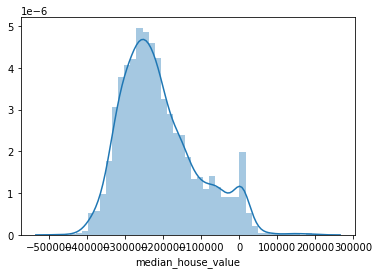

In [67]:
sns.distplot(y_test - final_predictions)

#### random search

In [91]:
final_model = rnd_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
print('rmse :', np.sqrt(final_mse))

rmse : 236823.5765674272


-3.3037864833654824

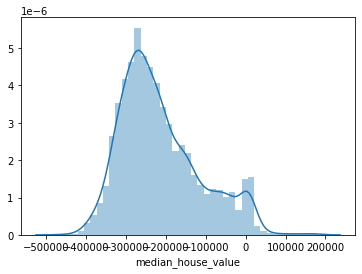

In [90]:
sns.distplot(y_test - final_predictions)

### Extra -- Using SVM

In [72]:
#from sklearn.model_selection import GridSearchCV
#from sklearn.svm import SVR

#param_grid = [
#        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
#        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
#         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
#    ]

#svm_reg = SVR()
#grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
#grid_search.fit(New_X_Train, Y_Train)

#negative_mse = grid_search.best_score_
#rmse = np.sqrt(-negative_mse)
#print(rmse)
#grid_search.best_params_

#final_model = grid_search.best_params_

#X_test = strat_test_set.drop("median_house_value", axis=1)
#y_test = strat_test_set["median_house_value"].copy()

#X_test_prepared = full_pipeline.transform(X_test)
#final_predictions = final_model.predict(X_test_prepared)

#final_mse = mean_squared_error(y_test, final_predictions)
#print('rmse :', np.sqrt(final_mse))

#grid = final_model
#grid.fit(X_test_prepared, y_test)
#print(grid.score(X_test_prepared, y_test))

# Regression

### Polynomial Regression with Ridge regression

In [134]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

# Same estimator as before
estimator = Pipeline([("scaler", StandardScaler()),
        ("polynomial_features", PolynomialFeatures()),
        ("ridge_regression", Ridge())])

params = {
    'polynomial_features__degree': [1, 2, 3],
    'ridge_regression__alpha': np.geomspace(4, 20, 30)
}

grid = GridSearchCV(estimator, params, cv=5)
grid.fit(New_X_Train, Y_Train)
grid.best_estimator_


final_model = grid.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
print('rmse :', np.sqrt(final_mse))
r2_score(y_test, final_predictions)

rmse : 1173916976659.9023


-105748840074475.9

AttributeError: 'Line2D' object has no property 'style'

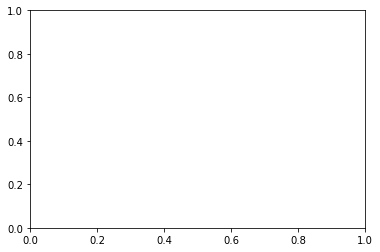

In [71]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

std_scaler = StandardScaler()
lin_reg = LinearRegression()
polynomial_regression = Pipeline([
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    
polynomial_regression.fit(New_X_Train, Y_Train)
y_newbig = polynomial_regression.predict(X_test_prepared)
plt.plot(y_test, y_newbig, style = 'g-')
plt.show()

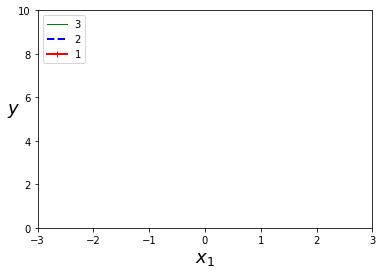

In [68]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

for style, width, degree in (("g-", 1, 3), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    
    polynomial_regression.fit(New_X_Train, Y_Train)
    y_newbig = polynomial_regression.predict(X_test_prepared)
    plt.plot(y_test, y_newbig, style, label=str(degree), linewidth=width)

#plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

In [150]:
from sklearn.linear_model import RidgeCV

alphas = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]

ridgeCV = RidgeCV(alphas=alphas, 
                  cv=4).fit(New_X_Train, Y_Train)

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = ridgeCV.predict(X_test_prepared)

ridgeCV_rmse = r2_score(y_test, ridgeCV.predict(X_test_prepared))

print(ridgeCV_rmse)

-3232684.509377193


In [173]:
from sklearn.linear_model import LassoCV

alphas2 = np.array([1e-5, 5e-5, 0.0001, 0.0005])

lassoCV = LassoCV(alphas=alphas2,
                  max_iter=5e4,
                  cv=3).fit(New_X_Train, Y_Train)

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = lassoCV.predict(X_test_prepared)

ridgeCV_rmse = r2_score(y_test, lassoCV.predict(X_test_prepared))

print(ridgeCV_rmse)

-3440647.8268616037


In [174]:
print('Of {} coefficients, {} are non-zero with Lasso.'.format(len(lassoCV.coef_), 
                                                               len(lassoCV.coef_.nonzero()[0])))

Of 13 coefficients, 13 are non-zero with Lasso.


In [198]:
# Import SGDRegressor and prepare the parameters

from sklearn.linear_model import SGDRegressor

model_parameters_dict = {
    'Linear': {'penalty': 'none'},
    'Lasso': {'penalty': 'l2',
           'alpha': lassoCV.alpha_},
    'Ridge': {'penalty': 'l1',
           'alpha': ridgeCV_rmse},
    'ElasticNet': {'penalty': 'elasticnet', 
                   'alpha': elasticNetCV.alpha_,
                   'l1_ratio': elasticNetCV.l1_ratio_}
}

new_rmses = {}
for modellabel, parameters in model_parameters_dict.items():
    # following notation passes the dict items as arguments
    SGD = SGDRegressor(**parameters)
    SGD.fit(New_X_Train, Y_Train)
    
    X_test = strat_test_set.drop("median_house_value", axis=1)
    y_test = strat_test_set["median_house_value"].copy()

    X_test_prepared = full_pipeline.transform(X_test)

    new_rmses[modellabel] = r2_score(y_test, SGD.predict(X_test_prepared))

rmse_df['RMSE-SGD'] = pd.Series(new_rmses)
rmse_df

ValueError: dimension mismatch